In [199]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
import time
from scipy import stats
from scipy import constants
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle


from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.nn import ReLU
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.12.1+cpu


In [200]:
# trainning and validation data
data_h_lhs=pd.read_csv('h_LHS_120mpa.csv',index_col=False)
data_lambda_lhs=pd.read_csv('lambda_LHS_120mpa.csv',index_col=False)
data_T_lhs=pd.read_csv('T_LHS_120mpa.csv',index_col=False)
data_strain_lhs=pd.read_csv('strain_LHS_120mpa.csv')



##testing data
data_h_uniform_5000=pd.read_csv('h_uniform_5000_120mpa.csv',index_col=False)
data_T_uniform_5000=pd.read_csv('T_uniform_5000_120mpa.csv',index_col=False)
data_lambda_uniform_5000=pd.read_csv('lambda_uniform_5000_120mpa.csv',index_col=False)
data_strain_uniform_5000=pd.read_csv('strain_uniform_5000_120mpa.csv',index_col=False)


## Actual data loading for fixed
strain_matlab=pd.read_csv('strain_atfixedh.csv')


In [235]:
### Reading values only for trainning data
h_in=data_h_lhs.values
T_in=data_T_lhs.values
Lambda_in=data_lambda_lhs.values
strain_in=data_strain_lhs.values

# converting to tensor
h_in_notscaled=torch.tensor(h_in).float()
T_in_notscaled=torch.tensor(T_in).float()
Lambda_in_notscaled=torch.tensor(Lambda_in).float()
strain_in_notscaled=torch.tensor(strain_in).float()




Lambda_in_test_5000=data_lambda_uniform_5000.values
strain_in_test_5000=data_strain_uniform_5000.values

# Scaling the input and outputs
min_max_scaler_h =MinMaxScaler()
min_max_scaler_T =MinMaxScaler()
min_max_scaler_lambda =MinMaxScaler()
min_max_scaler_strain=MinMaxScaler()

h_scale_in= min_max_scaler_h.fit_transform(h_in)
T_scale_in= min_max_scaler_T.fit_transform(T_in)
Lambda_scale_in= min_max_scaler_lambda.fit_transform(Lambda_in)
strain_scale_in=min_max_scaler_strain.fit_transform(strain_in)

## Converting into tensor for nn only 3000 data taken for trainning with LHS
h_tensor=torch.Tensor(h_scale_in)[0:3000]
T_tensor=torch.Tensor(T_scale_in)[0:3000]
Lambda_tensor=torch.Tensor(Lambda_scale_in)[0:3000]
strain_tensor=torch.Tensor(strain_scale_in)[0:3000]


# testing data 2000 from LHS
h_tensor_2000=torch.Tensor(h_scale_in)[3000:5000]
T_tensor_2000=torch.Tensor(T_scale_in)[3000:5000]
Lambda_tensor_2000=torch.Tensor(Lambda_scale_in)[3000:5000]
strain_tensor_2000=torch.Tensor(strain_scale_in)[3000:5000]


##test Data preparation generated from uniform input sampling
h_test_in_5000=data_h_uniform_5000.values
T_test_in_5000=data_T_uniform_5000.values
lambda_test_in_5000=data_lambda_uniform_5000.values
strain_test_in_5000=data_strain_uniform_5000.values

min_max_scaler_h_5000 =MinMaxScaler()
min_max_scaler_T_5000 =MinMaxScaler()
min_max_scaler_Lambda_5000=MinMaxScaler()
min_max_scaler_strain_5000=MinMaxScaler()

scale_h_test_in_5000=min_max_scaler_h_5000.fit_transform(h_test_in_5000)
scale_T_test_in_5000=min_max_scaler_T_5000.fit_transform(T_test_in_5000)
scale_Lambda_test_in_5000=min_max_scaler_Lambda_5000.fit_transform(lambda_test_in_5000)
scale_strain_test_in_5000=min_max_scaler_strain_5000.fit_transform(strain_test_in_5000)

h_tensor_5000=torch.Tensor(scale_h_test_in_5000)
T_tensor_5000=torch.Tensor(scale_T_test_in_5000)
Lambda_tensor_5000=torch.tensor(scale_Lambda_test_in_5000)
strain_tensor_5000=torch.tensor(scale_strain_test_in_5000)

# test data
h_in_notscaled_5000=torch.tensor(h_test_in_5000).float()
T_in_notscaled_5000=torch.tensor(T_test_in_5000).float()
lambda_in_notscaled_5000=torch.tensor(lambda_test_in_5000).float()
strain_in_notscaled_5000=torch.tensor(strain_test_in_5000).float()


# Matlab generated strain for fixed h
strain_test_in_500000=strain_matlab.values
scale_strain_test_in_500000=min_max_scaler_strain_5000.fit_transform(strain_test_in_500000)
strain_tensor_500000=torch.tensor(scale_strain_test_in_500000)



# zipped_tensor=zip(h_tensor,T_tensor,Lambda_tensor)
# tuple = (h_tensor, T_tensor)
# new_tensor = torch.cat(tuple,-1)
# T = torch.stack((h_tensor,T_tensor), -1)  ## this one is working
# new_tensor

In [202]:
# Making data for h constant and strain varry for stress strain graph keeping h constant

scale_h_test_in_5000.shape[0]
h=[]
for i in scale_h_test_in_5000[0:100]:
    for j in range(5000):
        h.append(i)
h=pd.DataFrame(h)


strain=pd.DataFrame(strain_tensor_5000)
df_repeated_strain = pd.concat([strain]*100, ignore_index=True)
# print(df_repeated_strain)
# df_repeated_strain_tensor=torch.Tensor(df_repeated_strain)



In [ ]:
# Making Dataframe for input to Matlab

# h dataframe for matlab
h_test_in_5000.shape[0]
h_matlab=[]
for i in h_test_in_5000[0:100]:
    for j in range(5000):
        h_matlab.append(i)
h_matlab=pd.DataFrame(h_matlab)

#stress dataframe for matlab
stress_matlab=pd.DataFrame(data_T_uniform_5000)
df_repeated_stress_matlab = pd.concat([stress_matlab]*100, ignore_index=True)


matlab_input=pd.concat([h_matlab,df_repeated_stress_matlab],axis=1)

matlab_input.to_csv('matlab_input.csv')

In [4]:
min(strain_test_in_5000)*10**6

array([-1590.])

In [5]:
h_tensor_5000[8],h_tensor_5000[13]

(tensor([0.0808]), tensor([0.1313]))

In [28]:
# data for T plot
# data_strain_Tplot=pd.read_csv('strain_for_T_plot_scaled.csv')
# data_strain_Tplot_in=data_strain_Tplot.values
# data_strain_Tplot_tensor=torch.tensor(data_strain_Tplot_in)
# data_strain_Tplot_tensor.shape

# h_tensor_tplot=h_tensor_5000[0:200]


# h constant and strain varry data
data_h_Tplot=pd.read_csv('hfor_T_plot_scaled_120mpa.csv')

data_h_Tplot_in=data_h_Tplot.values
# data_h_Tplot_in_scale=min_max_scaler_h.fit_transform(data_h_Tplot_in)
data_h_Tplot_tensor=torch.tensor(data_h_Tplot_in)

# strain_tensor_tplot=h_tensor_5000
##data_h_Tplot_tensor,strain_tensor_tplot


data_h_Tplot_22_3=pd.read_csv('hfor_T_plot_scaled_minmaxlhs_120mpa.csv')

data_h_Tplot_in_22_3=data_h_Tplot_22_3.values
# data_h_Tplot_in_scale=min_max_scaler_h.fit_transform(data_h_Tplot_in)
data_h_Tplot_tensor_22_3=torch.tensor(data_h_Tplot_in_22_3)


In [7]:
class Inverse(nn.Module):
        def __init__(self):
                super(Inverse, self).__init__()        
                self.LAMBDA = nn.Sequential(
                        nn.Linear(2, 32),
                        nn.ReLU(),
                        nn.Linear(32, 64),
                        nn.ReLU(),
                        nn.Linear(64, 1))

                self.stress = nn.Sequential(
                        nn.Linear(2, 32),
                        nn.ReLU(),
                        nn.Linear(32, 64),
                        nn.ReLU(),
                        nn.Linear(64, 1))
                        
                
        def forward(self,h,T):
                in_1=torch.concat((h,T),1)
                lam = self.LAMBDA(in_1) 
                in_2=torch.concat((lam,h),1) 
                T   = self.stress(in_2)  

                return lam,T          
model=Inverse()


In [8]:
loss_criteria=nn.MSELoss()
## Trainning function definition
alpha=1
beta=1
def train(model,h,T,lam,optimizer):
  for i in range(len(h)):
    model.train()
    
    # for i in range(len(h)):
    # optimizer.zero_grad()
    out1,out2=model(h,T)
    loss1=loss_criteria(out1,lam)
    loss2=loss_criteria(out2,T)
    loss=alpha*loss1+beta*loss2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss,out1,out2

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 10
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model,h_tensor,T_tensor,Lambda_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.20078617
Epoch: 2
0.1541589
Epoch: 3
0.14717081
Epoch: 4
0.14520536
Epoch: 5
0.14441201
Epoch: 6
0.14399639
Epoch: 7
0.14373846
Epoch: 8
0.14356963
Epoch: 9
0.1434315
Epoch: 10
0.14333001


<function matplotlib.pyplot.show(close=None, block=None)>

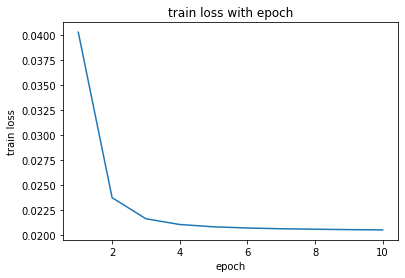

In [10]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [11]:
prediction_3000=model(h_tensor,T_tensor)
prediction_3000[1].shape
# predicton for the train data

torch.Size([3000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

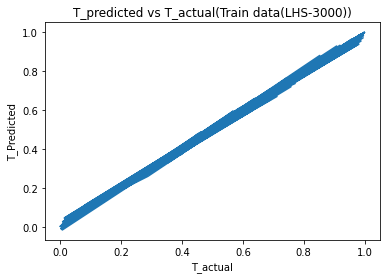

In [12]:
plt.plot(T_tensor,prediction_3000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for trainning data

<function matplotlib.pyplot.show(close=None, block=None)>

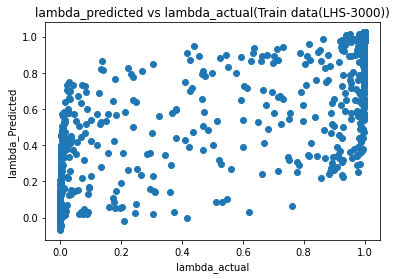

In [13]:
plt.scatter(Lambda_tensor,prediction_3000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_Predicted")
plt.title('lambda_predicted vs lambda_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for trainning data

In [14]:
prediction_2000=model(h_tensor_2000,T_tensor_2000)
## prediction for the remaining 2000 samples of LHS
prediction_2000[1].shape

torch.Size([2000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

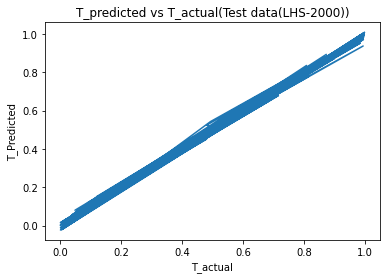

In [15]:
plt.plot(T_tensor_2000,prediction_2000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test data(LHS-2000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

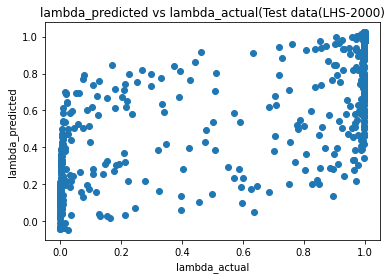

In [16]:
plt.scatter(Lambda_tensor_2000,prediction_2000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

In [17]:
predicted_lhs=min_max_scaler_lambda.inverse_transform(prediction_2000[0].detach().numpy())*10**6
actual_lhs=min_max_scaler_lambda.inverse_transform(Lambda_tensor_2000)*10**6

<function matplotlib.pyplot.show(close=None, block=None)>

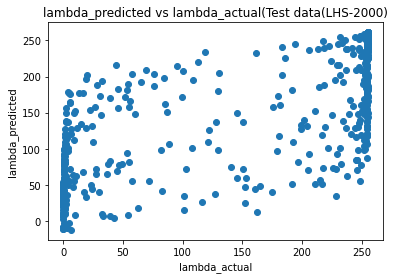

In [18]:
plt.scatter(actual_lhs,predicted_lhs)
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

In [19]:
prediction_5000=model(h_tensor_5000,T_tensor_5000)
## predoction fpr the data test data generated from uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 360x360 with 0 Axes>

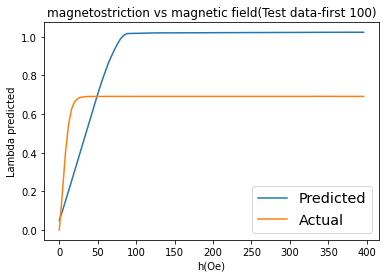

In [20]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(h_test_in_5000[0:100]/79.77,prediction_5000[0][0:100].detach().numpy(),label='Predicted')
plt.plot(h_test_in_5000[0:100]/79.77,(Lambda_tensor_5000[0:100]),label='Actual')
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
legend = ax.legend(loc='best', fontsize='x-large')
plt.title('magnetostriction vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T 

In [21]:
predicted_uni=min_max_scaler_Lambda_5000.inverse_transform(prediction_5000[0].detach().numpy())*10**6
actual_uni=min_max_scaler_Lambda_5000.inverse_transform(Lambda_tensor_5000)*10**6

<function matplotlib.pyplot.show(close=None, block=None)>

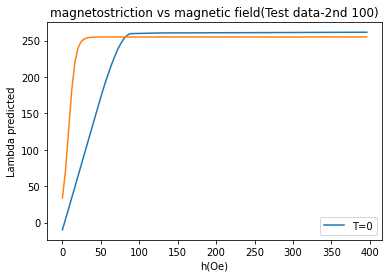

In [22]:
# plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[0:100])
# plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[0:100])
plt.plot(h_test_in_5000[100:200]/79.77,predicted_uni[100:200])
plt.plot(h_test_in_5000[100:200]/79.77,actual_uni[100:200])
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
plt.legend(['T=0'])
plt.title('magnetostriction vs magnetic field(Test data-2nd 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T

<function matplotlib.pyplot.show(close=None, block=None)>

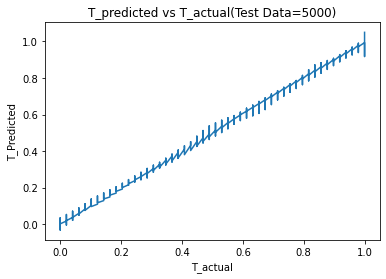

In [23]:
plt.plot(T_tensor_5000,prediction_5000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test Data=5000)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

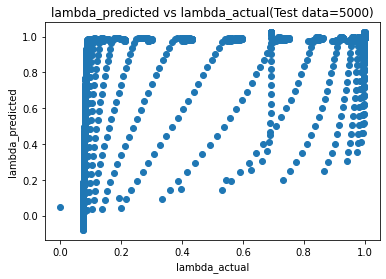

In [24]:
plt.scatter(Lambda_tensor_5000,prediction_5000[0].detach().numpy())
plt.xlabel("lambda_actual")
plt.ylabel("lambda_predicted")
plt.title('lambda_predicted vs lambda_actual(Test data=5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for uniform samples 

In [189]:
##Saving the model state of 50 epoch

# Additional information
EPOCH = 50
PATH = "model_well.pt"
LOSS = 0.015409946

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [19]:
##Loading model with 100 epoch

model = Inverse()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=2, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=1, bias=True)
)

In [9]:
model_strain=Inverse()

In [269]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model_strain.parameters(), lr=learning_rate)
# optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
# validation_loss = []


epochs = 25
for epoch in range(1, epochs + 1):

    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss,lambda_out,T_out = train(model_strain,h_tensor,T_tensor,strain_tensor , optimizer)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    print(np.sqrt(train_loss.detach().numpy()))
    # validation_loss.append(test_loss)

Epoch: 1
0.0008833267
Epoch: 2
0.0008589309
Epoch: 3
0.00088115706
Epoch: 4
0.00081364013
Epoch: 5
0.00079389097
Epoch: 6
0.0013282892
Epoch: 7
0.0007611001
Epoch: 8
0.00075375795
Epoch: 9
0.00073369016
Epoch: 10
0.00072644337
Epoch: 11
0.0007140336
Epoch: 12
0.00078272715
Epoch: 13
0.0007070662
Epoch: 14
0.0006916387
Epoch: 15
0.00068744685
Epoch: 16
0.0006796448
Epoch: 17
0.0007499247
Epoch: 18
0.00066881167
Epoch: 19
0.0006708163
Epoch: 20
0.000662035
Epoch: 21
0.00066161697
Epoch: 22
0.00065144413
Epoch: 23
0.00064637547
Epoch: 24
0.0007220841
Epoch: 25
0.0006425531


In [30]:
# pickle.dump(model, open('model.pkl', 'wb'))

<function matplotlib.pyplot.show(close=None, block=None)>

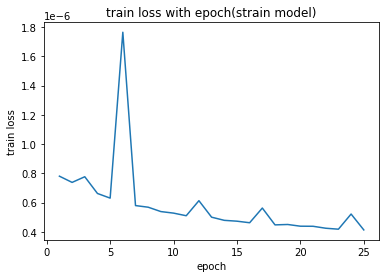

In [270]:
tensor_trainning_loss = torch.tensor(training_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title('train loss with epoch(strain model)')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [271]:
prediction_3000=model_strain(h_tensor,T_tensor)
# predicton for the train data

<function matplotlib.pyplot.show(close=None, block=None)>

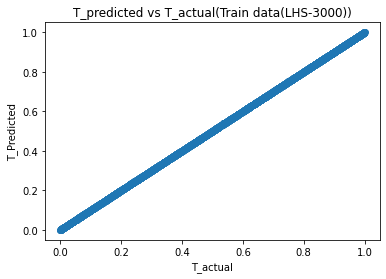

In [272]:
plt.scatter(T_tensor,prediction_3000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Train data(LHS-3000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for trainning data

In [273]:
prediction_2000=model_strain(h_tensor_2000,T_tensor_2000)
## prediction for the remaining 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

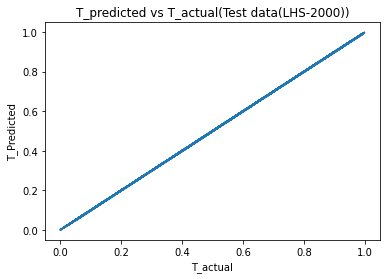

In [274]:
plt.plot(T_tensor_2000,prediction_2000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test data(LHS-2000))')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

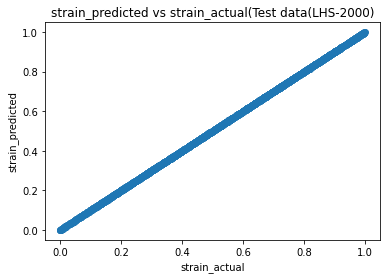

In [275]:
plt.scatter(strain_tensor_2000,prediction_2000[0].detach().numpy())
plt.xlabel("strain_actual")
plt.ylabel("strain_predicted")
plt.title('strain_predicted vs strain_actual(Test data(LHS-2000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

In [276]:
prediction_5000=model_strain(h_tensor_5000,T_tensor_5000)
prediction_5000[0].size()
strain_tensor_5000.size()
## predoction fpr the data test data generated from uniform input sampling

torch.Size([5000, 1])

<function matplotlib.pyplot.show(close=None, block=None)>

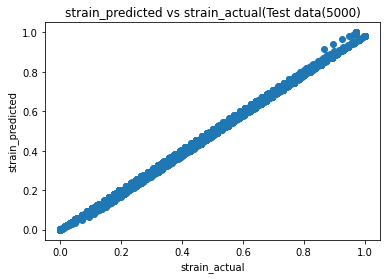

In [277]:
plt.scatter(strain_tensor_5000,prediction_5000[0].detach().numpy())
plt.xlabel("strain_actual")
plt.ylabel("strain_predicted")
plt.title('strain_predicted vs strain_actual(Test data(5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for 2000 samples of LHS

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 360x360 with 0 Axes>

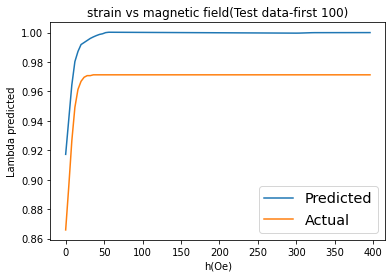

In [278]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(h_test_in_5000[0:100]/79.77,prediction_5000[0][0:100].detach().numpy(),label='Predicted')
plt.plot(h_test_in_5000[0:100]/79.77,(strain_tensor_5000[0:100]),label='Actual')
plt.xlabel("h(Oe)")
plt.ylabel("Lambda predicted")
# plt.legend(['T=0'])
legend = ax.legend(loc='best', fontsize='x-large')
plt.title('strain vs magnetic field(Test data-first 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T 

In [279]:
predicted_uni=min_max_scaler_strain_5000.inverse_transform(prediction_5000[0].detach().numpy())*10**6
actual_uni=min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 360x360 with 0 Axes>

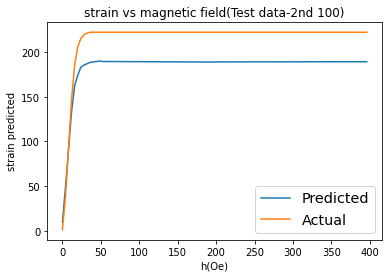

In [280]:
# plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[0:100])
# plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[0:100])

plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(h_test_in_5000[0:100]/79.77,predicted_uni[100:200],label='Predicted')
plt.plot(h_test_in_5000[0:100]/79.77,actual_uni[100:200],label='Actual')
plt.xlabel("h(Oe)")
plt.ylabel("strain predicted")
plt.legend(['T=96000'])
legend = ax.legend(loc='best', fontsize='x-large')
plt.title('strain vs magnetic field(Test data-2nd 100)')
# plt.yticks(np.linspace(170,200,10))
plt.show

## plotting lambda vs h plot for uniform samples and fixed T

<function matplotlib.pyplot.show(close=None, block=None)>

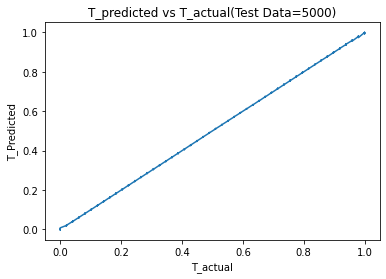

In [281]:
plt.plot(T_tensor_5000,prediction_5000[1].detach().numpy())
plt.xlabel("T_actual")
plt.ylabel("T_Predicted")
plt.title('T_predicted vs T_actual(Test Data=5000)')
# plt.yticks(np.linspace(0,-90,10))
plt.show

##plotting T predicted vs T actual graph for uniform input sampling

<function matplotlib.pyplot.show(close=None, block=None)>

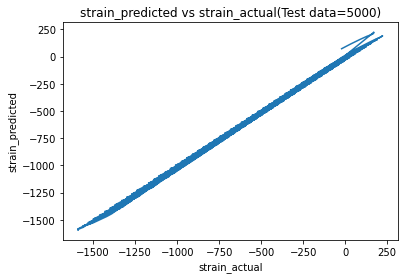

In [282]:
plt.plot(min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6,min_max_scaler_strain_5000.inverse_transform(prediction_5000[0].detach().numpy())*10**6)
plt.xlabel("strain_actual")
plt.ylabel("strain_predicted")
plt.title('strain_predicted vs strain_actual(Test data=5000)')
# plt.yticks(np.linspace(150,200,10))

plt.show

## plotting lambda precicted vs lambda actual for uniform samples 

In [283]:
# plt.figure(figsize=(5,5))
# fig, ax = plt.subplots()
# plt.plot(h_inverse[0:100]/79.77,stress_inverse[0:100]/10**6,label='strain=-0.00071672')
# plt.plot(h_inverse[100:200]/79.77,stress_inverse[100:200]/10**6,label='strain=-0.00078044')
# plt.xlabel("h")
# plt.ylabel("stress")
# plt.legend(["strain=-0.00071672"])
# legend = ax.legend(loc='best', fontsize='x-large')
# plt.title('magnetic field vs stress(Test data=200)')
# # plt.yticks(np.linspace(150,200,10))

In [284]:
# prediction from constant h and varrying strain and get T
# data_h_Tplot_tensor,strain_tensor_tplot
in_h_cons=torch.concat((strain_tensor_5000.float(),data_h_Tplot_tensor.float()),1)
stress_out_hcons=model_strain.stress(in_h_cons)

In [285]:
strain_actual_5000_24=pd.read_csv("strain_fixed_h_24.csv")

([<matplotlib.axis.XTick at 0x217dfad5510>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 360x360 with 0 Axes>

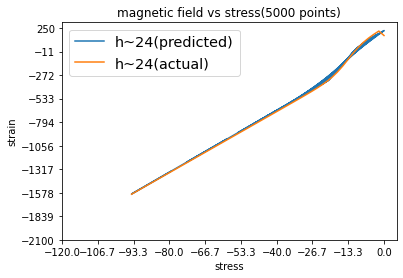

In [286]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons.detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6,label='h~24(predicted)')### which scalere to use for inverse scaling
# plt.plot(min_max_scaler_T.inverse_transform(stress_out_hcons.detach().numpy()[100:200])/10**6,min_max_scaler_strain.inverse_transform(strain_tensor_5000[100:200])*10**6,label='h=44.6')
plt.plot(T_test_in_5000/10**6,strain_actual_5000_24.values*10**6,label='h~24(actual)')
plt.xlabel("stress")
plt.ylabel("strain")
legend = ax.legend(loc='best', fontsize='x-large')
# plt.legend(["h=22.3 Oe"])
plt.title('magnetic field vs stress(5000 points)')
plt.yticks(np.linspace(250,-2100,10))
plt.xticks(np.linspace(0,-120,10))


## there is problem in plotting the real graph also...check for it...

In [287]:
# prediction from constant h and varrying strain and get T
# data_h_Tplot_tensor,strain_tensor_tplot
in_h_cons_22_3=torch.concat((strain_tensor_5000.float(),data_h_Tplot_tensor_22_3.float()),1)
stress_out_hcons_22_3=model_strain.stress(in_h_cons_22_3)

In [288]:
strain_actual_5000_22_3=pd.read_csv("strain_fixed_h_22.3.csv")

([<matplotlib.axis.XTick at 0x217dfb3fa30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 360x360 with 0 Axes>

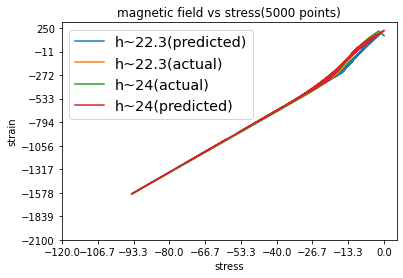

In [289]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3.detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6,label='h~22.3(predicted)')### which scalere to use for inverse scaling
# plt.plot(min_max_scaler_T.inverse_transform(stress_out_hcons.detach().numpy()[100:200])/10**6,min_max_scaler_strain.inverse_transform(strain_tensor_5000[100:200])*10**6,label='h=44.6')
plt.plot(T_test_in_5000/10**6,strain_actual_5000_22_3.values*10**6,label='h~22.3(actual)')
plt.plot(T_test_in_5000/10**6,strain_actual_5000_24.values*10**6,label='h~24(actual)')
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons.detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_5000)*10**6,label='h~24(predicted)')### which scalere to use for inverse scaling

plt.xlabel("stress")
plt.ylabel("strain")
legend = ax.legend(loc='best', fontsize='x-large')
# plt.legend(["h=22.3 Oe"])
plt.title('magnetic field vs stress(5000 points)')
plt.yticks(np.linspace(250,-2100,10))
plt.xticks(np.linspace(0,-120,10))


## there is problem in plotting the real graph also...check for it...

In [290]:
input_strain=torch.Tensor(df_repeated_strain.values)
input_h=torch.Tensor(h.values)

In [291]:
strain_tensor_500000.shape

torch.Size([500000, 1])

In [292]:
# prediction from constant h and varrying strain and get T
# data_h_Tplot_tensor,strain_tensor_tplot
in_h_cons_22_3=torch.concat((strain_tensor_500000.float(),input_h),1)
stress_out_hcons_22_3=model_strain.stress(in_h_cons_22_3)

Text(0.5, 1.0, 'stress vs strain(500000 points)')

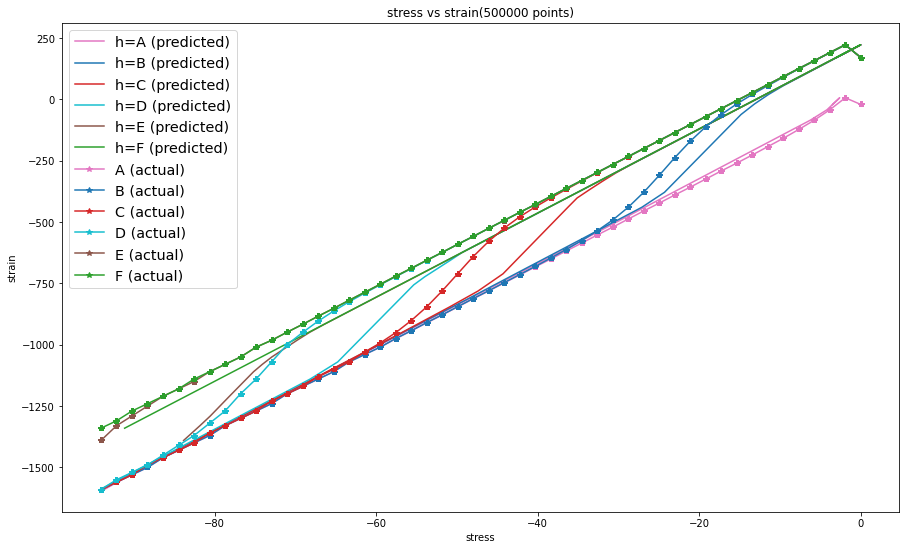

In [297]:
fig, ax = plt.subplots(figsize=(15,9))
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[0:5000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[0:5000])*10**6,c='C6',label='h=A (predicted)')
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[50000:55000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[50000:55000])*10**6,c='C10',label='h=B (predicted)')
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[100000:105000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[100000:105000])*10**6,c='C13',label='h=C (predicted)')
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[150000:155000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[150000:155000])*10**6,c='C19',label='h=D (predicted)')
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[200000:205000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[200000:205000])*10**6, c='C25',label='h=E (predicted)')
# # plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[300000:305000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[300000:305000].values)*10**6)
# # plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[400000:405000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[400000:405000].values)*10**6)
plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[495000:500000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(strain_tensor_500000[495000:500000])*10**6,c='C22',label='h=F (predicted)')

plt.plot(df_repeated_stress_matlab[0:5000]/10**6,strain_matlab[0:5000]*10**6,marker="*",c='C6',label='A (actual)')
plt.plot(df_repeated_stress_matlab[50000:55000]/10**6,strain_matlab[50000:55000]*10**6,marker="*",c='C10',label='B (actual)')
plt.plot(df_repeated_stress_matlab[100000:105000]/10**6,strain_matlab[100000:105000]*10**6,marker="*",c='C13',label='C (actual)')
plt.plot(df_repeated_stress_matlab[150000:155000]/10**6,strain_matlab[150000:155000]*10**6,marker="*",c='C19',label='D (actual)')
plt.plot(df_repeated_stress_matlab[200000:205000]/10**6,strain_matlab[200000:205000]*10**6,marker="*",c='C25',label='E (actual)')
plt.plot(df_repeated_stress_matlab[495000:500000]/10**6,strain_matlab[495000:500000]*10**6,marker="*",c='C22',label='F (actual)')

plt.xlabel("stress")
plt.ylabel("strain")
legend = ax.legend(loc='best', fontsize='x-large')
# plt.legend(["h=22.3 Oe"])
plt.title('stress vs strain(500000 points)')
# plt.yticks(np.linspace(250,-2100,8))
# plt.xticks(np.linspace(0,-120,8))


Text(0.5, 1.0, 'stress vs strain(500000 points)')

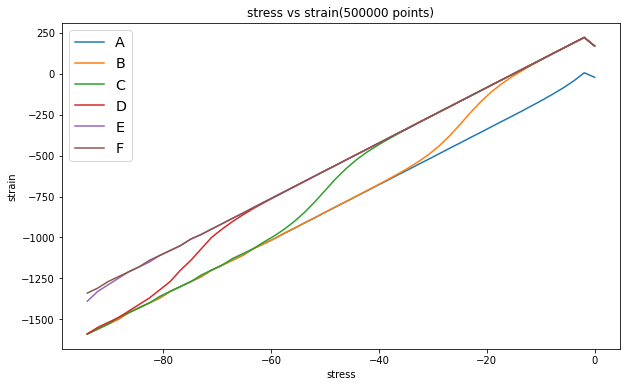

In [294]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_repeated_stress_matlab[0:5000]/10**6,strain_matlab[0:5000]*10**6,label='A')
plt.plot(df_repeated_stress_matlab[50000:55000]/10**6,strain_matlab[50000:55000]*10**6,label='B')
plt.plot(df_repeated_stress_matlab[100000:105000]/10**6,strain_matlab[100000:105000]*10**6,label='C')
plt.plot(df_repeated_stress_matlab[150000:155000]/10**6,strain_matlab[150000:155000]*10**6,label='D')
plt.plot(df_repeated_stress_matlab[200000:205000]/10**6,strain_matlab[200000:205000]*10**6,label='E')
plt.plot(df_repeated_stress_matlab[495000:500000]/10**6,strain_matlab[495000:500000]*10**6,label='F')
# plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[100000:105000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[100000:105000].values)*10**6,label='h=B Oe(predicted)')
# plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[150000:155000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[150000:155000].values)*10**6,label='h=C Oe(predicted)')
# plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[200000:205000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[200000:205000].values)*10**6, label='h=D Oe(predicted)')
# # plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[300000:305000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[300000:305000].values)*10**6)
# # plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[400000:405000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[400000:405000].values)*10**6)
# plt.plot(min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[495000:500000].detach().numpy())/10**6,min_max_scaler_strain_5000.inverse_transform(df_repeated_strain[495000:500000].values)*10**6,label='h=400 Oe(predicted)')

plt.xlabel("stress")
plt.ylabel("strain")
legend = ax.legend(loc='best', fontsize='x-large')
# plt.legend(["h=22.3 Oe"])
plt.title('stress vs strain(500000 points)')
# plt.yticks(np.linspace(250,-2100,8))
# plt.xticks(np.linspace(0,-120,8))

In [295]:
min_max_scaler_T_5000.inverse_transform(stress_out_hcons_22_3[150000:155000].detach().numpy()),df_repeated_stress_matlab[150000:155000]

(array([[ -3027164.5],
        [ -3027164.5],
        [ -3027164.5],
        ...,
        [-94200416. ],
        [-94200416. ],
        [-94200416. ]], dtype=float32),
                T
 150000         0
 150001         0
 150002         0
 150003         0
 150004         0
 ...          ...
 154995 -94080000
 154996 -94080000
 154997 -94080000
 154998 -94080000
 154999 -94080000
 
 [5000 rows x 1 columns])